In [1]:
# CSE545-SDG3-Matrix


In [2]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *
from pyspark.sql.window import *
from pyspark.sql.types import *
import os

In [3]:
sconf = pyspark.SparkConf()
sc = pyspark.SparkContext(appName="SDG3-TeamMatrix")
sqlCtx = SQLContext(sc)
sconf.set("spark.driver.maxResultSize", "36g")
sconf.set("spark.driver.memory", "36g")
sconf.set("spark.executor.memory", "36g")
sconf.set("spark.core.connection.ack.wait.timeout", "120000")
sc.version

'2.2.1'

In [4]:
data_path = r'../LinkPE14US'
print(os.path.join(data_path, "*.*PUB"))#all
#print(os.path.join(data_path, "VS14LINK.USMERGEDPUB"))#*.*PUB
df = sqlCtx.read.text(os.path.join(data_path, "*.*PUB"))  #all #*.*PUB
#df = sqlCtx.read.text(os.path.join(data_path, "VS14LINK.USMERGEDPUB"))  #merged
#df = sqlCtx.read.text(os.path.join(data_path, "VS14LINK.USNUMPUB"))  #350 mb
#df = sqlCtx.read.text("/VS14LINK.USDENPUB") # 5gb
#df = sqlCtx.read.text("/*.*PUB") # both
#df = df.sample(withReplacement=True,fraction=0.01, seed=42)

df.count()



../LinkPE14US/*.*PUB


4021418

In [5]:
#- eading

In [6]:
#logic to convert directly to numeric
def blank_as_1(x):
    return when(col(x) == '', 1).otherwise(0) # 1 == alive, 0 == demised for ICD10

In [7]:
# pandas data frame after adding column metadata
#pndf type = pyspark.sql.dataframe.DataFrame
pndf = df.select(
    df.value.substr(9,4).cast(IntegerType()).alias('Birth_Year'),
    df.value.substr(13,2).cast(IntegerType()).alias('Birth_Month'),
    df.value.substr(19,4).cast(IntegerType()).alias('Time_of_Birth'),
    df.value.substr(23,1).cast(IntegerType()).alias('Birth_DOW'),
    df.value.substr(32,1).cast(IntegerType()).alias('Birth_Place'),
    df.value.substr(50,1).cast(IntegerType()).alias('Facility_Recode'),
    df.value.substr(75,2).cast(IntegerType()).alias('Mothers_Age_Recode'),
    df.value.substr(84,1).cast(IntegerType()).alias('Mothers_Nativity'),
    df.value.substr(104,1).cast(IntegerType()).alias('Residence_Status'),
    df.value.substr(105,2).cast(IntegerType()).alias('Mothers_Race'),
    df.value.substr(110,1).cast(IntegerType()).alias('Bridge_Race_Mother'),
    df.value.substr(115,1).cast(IntegerType()).alias('Mothers_Hispanic_Origin_Recode'),
    df.value.substr(119,1).cast(IntegerType()).alias('Paternity_Ack'),
    df.value.substr(120,1).cast(IntegerType()).alias('Marital_Status'),
    df.value.substr(124,1).cast(IntegerType()).alias('Mothers_Education'),
    df.value.substr(147,2).cast(IntegerType()).alias('Fathers_Age'),
    df.value.substr(149,2).cast(IntegerType()).alias('Fathers_Age_Recode'),
    df.value.substr(151,2).cast(IntegerType()).alias('Fathers_Race_Recode'),
    df.value.substr(156,1).cast(IntegerType()).alias('Bridge_Race_Father'),
    df.value.substr(160,1).cast(IntegerType()).alias('Fathers_Hispanic_Origin_Recode'),
    df.value.substr(163,1).cast(IntegerType()).alias('Fathers_Education'),
    df.value.substr(171,2).cast(IntegerType()).alias('Prior_Births_Living'),
    df.value.substr(173,2).cast(IntegerType()).alias('Prior_Births_Dead'),
    df.value.substr(175,2).cast(IntegerType()).alias('Prior_Other_Terminations'),
    df.value.substr(179,1).cast(IntegerType()).alias('Live_Birth_Order_Recode'),
    df.value.substr(182,1).cast(IntegerType()).alias('Total_Birth_Order_Recode'),
    df.value.substr(198,3).cast(IntegerType()).alias('Interval_Last_Live_Birth_Recode'),
    df.value.substr(201,2).cast(IntegerType()).alias('Interval_Last_Live_Birth_Recode11'),
    df.value.substr(206,3).cast(IntegerType()).alias('Interval_Last_Other_Pregnancy_Recode'),
    df.value.substr(209,2).cast(IntegerType()).alias('Interval_Last_Other_Pregnancy_Recode11'),
    df.value.substr(214,3).cast(IntegerType()).alias('Interval_Last_Pregnancy_Recode'),
    df.value.substr(217,2).cast(IntegerType()).alias('Interval_Last_Pregnancy_Recode11'),
    df.value.substr(238,2).cast(IntegerType()).alias('Num_Prenatal_Visits'),
    df.value.substr(242,2).cast(IntegerType()).alias('Num_Prenatal_Visits_Recode'),
    df.value.substr(253,2).cast(IntegerType()).alias('Cigarettes_Before_Pregnancy'),
    df.value.substr(255,2).cast(IntegerType()).alias('Cigarettes_1st_Trimester'),
    df.value.substr(257,2).cast(IntegerType()).alias('Cigarettes_2nd_Trimester'),
    df.value.substr(259,2).cast(IntegerType()).alias('Cigarettes_3rd_Trimester'),
    df.value.substr(261,1).cast(IntegerType()).alias('Cigarettes_Before_Pregnancy_Recode'),
    df.value.substr(262,1).cast(IntegerType()).alias('Cigarettes_1st_Trimester_Recode'),
    df.value.substr(263,1).cast(IntegerType()).alias('Cigarettes_2nd_Trimester_Recode'),
    df.value.substr(264,1).cast(IntegerType()).alias('Cigarettes_3rd_Trimester_Recode'),
    df.value.substr(280,2).cast(IntegerType()).alias('Mothers_Height_Inches'),
    df.value.substr(287,1).cast(IntegerType()).alias('BMI_Recode'),
    df.value.substr(292,3).cast(IntegerType()).alias('Pre_Pregnancy_Weight_Recode'),
    df.value.substr(299,3).cast(IntegerType()).alias('Delivery_Weight_Recode'),
    df.value.substr(304,2).cast(IntegerType()).alias('Weight_Gain'),
    df.value.substr(306,1).cast(IntegerType()).alias('Weight_Gain_Recode'),
    df.value.substr(313,1).cast(StringType()).alias('Pre_Pregnancy_Diabetes'),
    df.value.substr(314,1).cast(StringType()).alias('Gestational_Diabetes'),
    df.value.substr(315,1).cast(StringType()).alias('Pre_Pregnancy_Hypertension'),
    df.value.substr(316,1).cast(StringType()).alias('Gestational_Hypertension'),
    df.value.substr(317,1).cast(StringType()).alias('Hypertension_Eclmapsia'),
    df.value.substr(318,1).cast(StringType()).alias('Previous_Preterm_Birth'),
    df.value.substr(325,1).cast(StringType()).alias('Infertility_Treatment'),
    df.value.substr(326,1).cast(StringType()).alias('Fertility_Enhancing_Drugs'),
    df.value.substr(327,1).cast(StringType()).alias('Assistive_Reproductive_Technology'),
    df.value.substr(331,1).cast(StringType()).alias('Prev_Cesareans'),
    df.value.substr(332,2).cast(IntegerType()).alias('Num_Prev_Cesareans'),
    df.value.substr(337,1).cast(StringType()).alias('No_Risk_Factors_Checked'),
    
    df.value.substr(343,1).cast(StringType()).alias('Gonorrhea'),
    df.value.substr(344,1).cast(StringType()).alias('Syphillis'),
    df.value.substr(345,1).cast(StringType()).alias('Chlamydia'),
    df.value.substr(346,1).cast(StringType()).alias('HepatitisB'),
    df.value.substr(347,1).cast(StringType()).alias('HepatitisC'),
    df.value.substr(353,1).cast(StringType()).alias('No_Infections_Checked'),
    df.value.substr(360,1).cast(StringType()).alias('Sucessful_External_Cephalic_Version'),
    df.value.substr(361,1).cast(StringType()).alias('Failed_External_Cephalic_Version'),
    
    df.value.substr(383,1).cast(StringType()).alias('Induction_Of_Labor'),
    df.value.substr(384,1).cast(StringType()).alias('Augmentation_Of_Labor'),
    df.value.substr(385,1).cast(StringType()).alias('Steroids_Mother'),
    df.value.substr(386,1).cast(StringType()).alias('Antibiotics_Mother'),
    df.value.substr(386,1).cast(StringType()).alias('Chorioamnionitis_Mother'),
    df.value.substr(387,1).cast(StringType()).alias('Anesthesia_Mother'),
    df.value.substr(395,1).cast(StringType()).alias('No_Labor_Checked'),
    df.value.substr(401,1).cast(IntegerType()).alias('Fetal_Presentation'),
    df.value.substr(402,1).cast(IntegerType()).alias('Final_Route_and_Method_Of_Delivery'),
    df.value.substr(403,1).cast(IntegerType()).alias('Trail_Of_Labor_Attempted'),
    df.value.substr(407,1).cast(IntegerType()).alias('Delivery_Method_Recode'),
    df.value.substr(415,1).cast(StringType()).alias('Maternal_Transfusion'),
    df.value.substr(416,1).cast(StringType()).alias('Perineal_Laceration'),
    df.value.substr(417,1).cast(StringType()).alias('Ruptured_Uterus'),
    df.value.substr(418,1).cast(StringType()).alias('Unplanned_Hysterectomy'),
    df.value.substr(419,1).cast(StringType()).alias('Admit_to_Intensive_Care'),
    df.value.substr(427,1).cast(IntegerType()).alias('No_Maternal_Morbidity_Checked'),
    df.value.substr(433,1).cast(IntegerType()).alias('Attendant'),
    df.value.substr(434,1).cast(StringType()).alias('Mother_Transferred'),

    
    #435 - 870
    df.value.substr(435,1).cast(IntegerType()).alias('Payment_Source'),
    df.value.substr(436,1).cast(IntegerType()).alias('Payment_Recode'),
    df.value.substr(444,2).cast(IntegerType()).alias('Five_Minute_APGAR_Score'),
    df.value.substr(446,1).cast(IntegerType()).alias('Five_Minute_APGAR_Recode'),
    df.value.substr(448,2).cast(IntegerType()).alias('Ten_Minute_APGAR_Score'),
    df.value.substr(450,1).cast(IntegerType()).alias('Ten_Minute_APGAR_Recode'),
    df.value.substr(454,1).cast(IntegerType()).alias('Plurality'),
    df.value.substr(475,1).cast(StringType()).alias('Sex_Of_Infant'),
    df.value.substr(477,2).cast(IntegerType()).alias('Last_Normal_Menses_Month'),
    df.value.substr(481,4).cast(IntegerType()).alias('Last_Normal_Menses_Year'),
    df.value.substr(489,1).cast(IntegerType()).alias('Obstetric_Estimate_of_Gestation_Used_Flag'),
    df.value.substr(490,2).cast(IntegerType()).alias('Combined_Gestation_Detail_in_Weeks'),
    df.value.substr(492,1).cast(IntegerType()).alias('Combined_Gestation_Recode_Weeks'),
    df.value.substr(509,2).cast(IntegerType()).alias('Birth_Weight_Recode_14'),
    df.value.substr(511,1).cast(IntegerType()).alias('Birth_Weight_Recode_4'),
    df.value.substr(512,4).cast(IntegerType()).alias('Imputed_Birthwieght'),
    #Abnormal Conditions of the Newborn
    df.value.substr(517,1).cast(StringType()).alias('Assisted_Ventilation'),
    df.value.substr(518,1).cast(StringType()).alias('Assisted_Ventilation_Greater_Than_6_Hours'),
    df.value.substr(519,1).cast(StringType()).alias('Admission_to_NICU'),
    df.value.substr(520,1).cast(StringType()).alias('Surfactant'),
    df.value.substr(521,1).cast(StringType()).alias('Antibiotics'),
    df.value.substr(522,1).cast(StringType()).alias('Seizures'),
    df.value.substr(531,1).cast(IntegerType()).alias('No_Abnormal_Conditions_Checked'),
    #Congenital Anomalies of the Newborn
    df.value.substr(537,1).cast(StringType()).alias('Anencephaly'),
    df.value.substr(538,1).cast(StringType()).alias('Meningomyelocele_or_Spina_Bifida'),
    df.value.substr(539,1).cast(StringType()).alias('Cyanotic_Congenital_Heart_Disease'),
    df.value.substr(540,1).cast(StringType()).alias('Congenital_Diaphragmatic_Hernia'),
    df.value.substr(541,1).cast(StringType()).alias('Omphalocele'),
    df.value.substr(542,1).cast(StringType()).alias('Gastroschisis'),
    df.value.substr(549,1).cast(StringType()).alias('Limb_Reduction_Defect'),
    df.value.substr(550,1).cast(StringType()).alias('Cleft_Lip_w_or_wo_Cleft_Palate'),
    df.value.substr(551,1).cast(StringType()).alias('Cleft_Palate_alone'),
    df.value.substr(553,1).cast(StringType()).alias('Suspected_Chromosomal_Disorder'),
    df.value.substr(554,1).cast(StringType()).alias('Hypospadias'),
    df.value.substr(561,1).cast(IntegerType()).alias('No_Congenital_Anomalies_Checked'),
    df.value.substr(568,1).cast(StringType()).alias('Infant_Living_at_Time_of_Report'),
    df.value.substr(569,1).cast(StringType()).alias('Infant_Being_Breastfed'), 
    #
    #1330 - 1743
    df.value.substr(1331,1).cast(IntegerType()).alias('Diabetes'),
    df.value.substr(1332,1).cast(IntegerType()).alias('Chronic_Hypertension'),
    df.value.substr(1333,1).cast(IntegerType()).alias('Prepregnacy_Associated_Hypertension'),
    df.value.substr(1334,1).cast(IntegerType()).alias('Eclampsia'),
    df.value.substr(1335,1).cast(IntegerType()).alias('Forceps'),
    df.value.substr(1336,1).cast(IntegerType()).alias('Vacuum'),
    df.value.substr(1337,1).cast(IntegerType()).alias('Induction_of_Labor1'),
    df.value.substr(1338,1).cast(IntegerType()).alias('Breech1'),
    df.value.substr(1341,1).cast(IntegerType()).alias('Spina_Bifida_Meningocele1'),
    df.value.substr(1342,1).cast(IntegerType()).alias('Omphalocele_Gastroschisis1'),
    
    df.value.substr(1343,1).cast(IntegerType()).alias('Cleft_Lip_Palate1'), 
    df.value.substr(1344,1).cast(IntegerType()).alias('Diaphragmatic_Herni1a'),
    df.value.substr(1345,1).cast(IntegerType()).alias('Down_Syndrome1'),
    df.value.substr(1356,3).cast(IntegerType()).alias('Age_at_Death_in_Days'),
    df.value.substr(1359,1).cast(IntegerType()).alias('Infant_age_recode_5'),
    df.value.substr(1360,2).cast(IntegerType()).alias('Infant_age_recode_22'), 
    df.value.substr(1362,1).cast(IntegerType()).alias('Manner_of_Death'),
    
    df.value.substr(1366,1).cast(IntegerType()).alias('Place_of_injury_for_causes_W00_Y34_except_Y06'),
    df.value.substr(1368,4).cast(StringType()).alias('ICD10'), #underlying cause of death - this is used to determine the LABEL for ML
    df.value.substr(1671,1).cast(IntegerType()).alias('Day_of_Week_of_Death'),
    df.value.substr(1672,4).cast(IntegerType()).alias('Data_Year'),
    df.value.substr(1742,1).cast(IntegerType()).alias('Month_of_Death')
    
    
).withColumn("id", monotonically_increasing_id())

pndf.printSchema
pndf = pndf.na.fill({'Num_Prev_Cesareans': 0.0})

# derive the infant_living column from ICD10 - must for ML prediction
ndf = pndf.withColumn("Infant_Living", blank_as_1("ICD10")) # dervied 0/1 label  # 1 == alive, 0 == demised for ICD10
print("number of features ", len(df.columns))

number of features  1


In [8]:
# how many infants demised
ndf.filter(ndf['Infant_Living']== 0).count()

0

In [9]:
ndf.filter(ndf['Birth_Year'] == 2014).count()

4018738

In [10]:
def blank_as_null(x):
    return when(col(x) != ' ', col(x)).otherwise(np.nan)


In [11]:
# pandas data frame after adding column metadata

ndf.printSchema
#pndf = ndf.na.fill("NA")
pndf = ndf.toPandas()
#pndf.replace("", np.nan, regex=True)
pndf.head(30)

,Birth_Year,Birth_Month,Time_of_Birth,Birth_DOW,Birth_Place,Facility_Recode,Mothers_Age_Recode,Mothers_Nativity,Residence_Status,Mothers_Race,...,Infant_age_recode_5,Infant_age_recode_22,Manner_of_Death,Place_of_injury_for_causes_W00_Y34_except_Y06,ICD10,Day_of_Week_of_Death,Data_Year,Month_of_Death,id,Infant_Living
0,2014,6.0,1436.0,4.0,1.0,1.0,23.0,1.0,1.0,2.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,0,1
1,2014,6.0,821.0,4.0,1.0,1.0,32.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,1,1
2,2014,6.0,2333.0,4.0,1.0,1.0,36.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,2,1
3,2014,6.0,1855.0,4.0,1.0,1.0,30.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,3,1
4,2014,6.0,1913.0,4.0,1.0,1.0,28.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,4,1
5,2014,6.0,122.0,4.0,1.0,1.0,39.0,2.0,1.0,4.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,5,1
6,2014,6.0,1422.0,5.0,1.0,1.0,35.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,6,1
7,2014,6.0,1237.0,5.0,1.0,1.0,22.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,7,1
8,2014,6.0,1451.0,5.0,1.0,1.0,38.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,8,1
9,2014,6.0,329.0,5.0,1.0,1.0,23.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,9,1


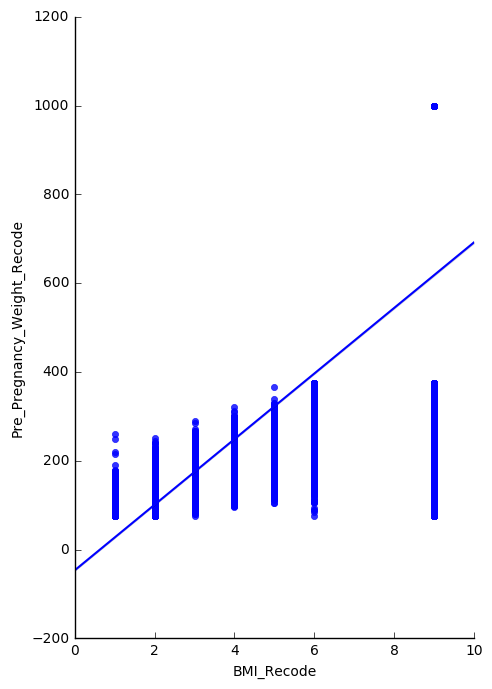

In [12]:
# conventional way to import seaborn
import seaborn as sns

# allow plots to appear within the notebook
%matplotlib inline

# visualize the relationship between the features and the response using scatterplots
sns.pairplot(pndf, x_vars=['BMI_Recode'], y_vars='Pre_Pregnancy_Weight_Recode', size=7, aspect=0.7, kind='reg')


In [13]:
# how many infants demised
pndf.filter(pndf['Infant_Living']==0).count()

Series([], dtype: int64)

In [14]:
pndf.shape

(4021418, 148)

In [15]:
#featureDf = ndf.withColumn("Delivery_Weight_gms", toInt(df['Delivery_Weight_lbs'])).select('Delivery_Weight_lbs')

In [16]:
#pndf[pd.isnull(pndf['Infant_Living'])]
#pndf[pndf.Infant_Living == None]
pndf.Infant_Living.unique()

array([1, 0])

In [17]:
pndf.ICD10.unique()

array(['', 'R99 ', 'R95 ', 'G129', 'A419', 'W75 ', 'P77 ', 'P523', 'P236',
       'Q897', 'Y09 ', 'Q913', 'P271', 'W65 ', 'I422', 'X599', 'C719',
       'G931', 'K566', 'B375', 'I678', 'E872', 'Q249', 'G919', 'I514',
       'I272', 'W84 ', 'E742', 'K650', 'K529', 'Q871', 'D471', 'G002',
       'Q794', 'A401', 'X49 ', 'A090', 'P369', 'X590', 'J849', 'J156',
       'P292', 'G404', 'J40 ', 'E550', 'C499', 'Q917', 'Y069', 'J181',
       'Q938', 'P220', 'J219', 'Q909', 'P910', 'B348', 'D849', 'B341',
       'Q210', 'K902', 'W83 ', 'W78 ', 'Q613', 'G409', 'I509', 'J860',
       'Q039', 'J152', 'J180', 'Q273', 'B349', 'P279', 'X85 ', 'J984',
       'J988', 'Q899', 'Q223', 'G122', 'X00 ', 'Q419', 'Q892', 'Q256',
       'P614', 'I743', 'P072', 'P219', 'E889', 'I420', 'K909', 'P360',
       'I99 ', 'Q999', 'W79 ', 'Y079', 'Q336', 'Q790', 'V877', 'Q234',
       'K560', 'Q898', 'W13 ', 'X30 ', 'J982', 'J129', 'C749', 'J398',
       'Q043', 'C798', 'Q935', 'A394', 'Q213', 'Q246', 'M628', 'G709',
  

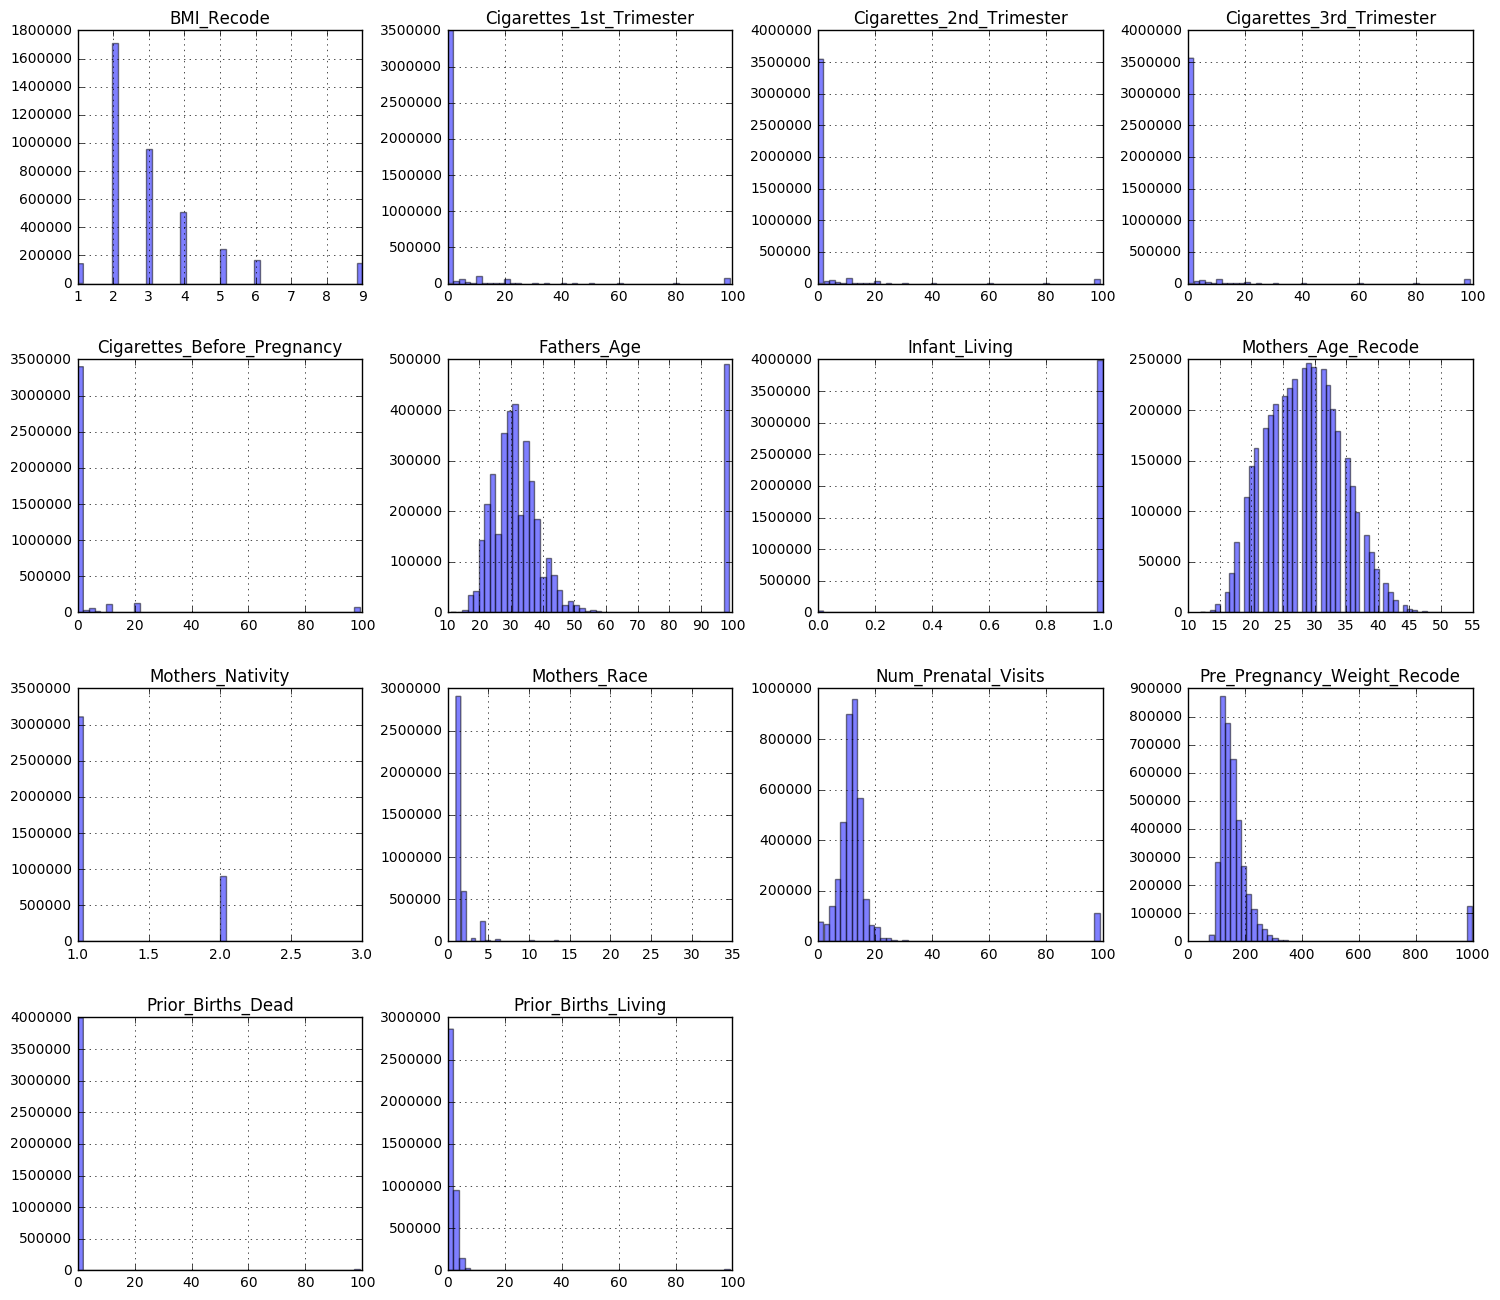

In [18]:
pndf_corr = pndf[['Mothers_Age_Recode','Mothers_Nativity','Mothers_Race','Prior_Births_Living',\
                  'Prior_Births_Dead','Fathers_Age','Num_Prenatal_Visits','Cigarettes_Before_Pregnancy',\
                  'Cigarettes_1st_Trimester','Cigarettes_2nd_Trimester','Cigarettes_3rd_Trimester','BMI_Recode',\
                  'Pre_Pregnancy_Weight_Recode','Infant_Living']]
'''
pndf_corr = pndf[['Mothers_Age_Recode','Mothers_Nativity','Mothers_Race','Prior_Births_Living',\
                      'Prior_Births_Dead','Fathers_Age','Num_Prenatal_Visits']]
'''
pndf_corr.hist(figsize=(18, 16), alpha=0.5, bins=50)
plt.show()
#fig.savefig('Distributions.png') 

In [19]:
pndf.describe()

/home/ubuntu/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Birth_Year,Birth_Month,Time_of_Birth,Birth_DOW,Birth_Place,Facility_Recode,Mothers_Age_Recode,Mothers_Nativity,Residence_Status,Mothers_Race,...,Age_at_Death_in_Days,Infant_age_recode_5,Infant_age_recode_22,Manner_of_Death,Place_of_injury_for_causes_W00_Y34_except_Y06,Day_of_Week_of_Death,Data_Year,Month_of_Death,id,Infant_Living
count,4.021418e+06,4.021260e+06,3.877513e+06,4.021260e+06,3.877513e+06,4.021260e+06,4.021260e+06,4.021260e+06,4.021260e+06,3.886538e+06,...,23243.000000,23243.000000,23243.000000,20235.000000,1421.000000,23243.000000,23243.0,23243.000000,4.021418e+06,4.021418e+06
mean,2.013999e+03,6.588621e+00,1.236574e+03,4.037504e+00,1.033284e+00,1.015365e+00,2.834729e+01,1.230115e+00,1.309132e+00,1.594228e+00,...,41.698963,3.198425,7.240761,6.337435,1.389163,4.039324,2014.0,0.250097,1.691982e+11,9.942202e-01
std,2.580674e-02,3.421388e+00,6.387608e+02,1.846960e+00,3.075500e-01,1.233231e-01,5.893635e+00,4.268382e-01,5.228504e-01,1.756236e+00,...,72.695854,1.498972,5.944631,1.574671,3.144612,1.984017,0.0,0.433078,1.001650e+11,7.580500e-02
min,2.013000e+03,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.200000e+01,1.000000e+00,1.000000e+00,1.000000e+00,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2014.0,0.000000,0.000000e+00,0.000000e+00
25%,2.014000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.589936e+10,1.000000e+00
50%,2.014000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.717987e+11,1.000000e+00
75%,2.014000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.576981e+11,1.000000e+00
max,2.014000e+03,1.200000e+01,9.999000e+03,7.000000e+00,9.000000e+00,3.000000e+00,5.000000e+01,3.000000e+00,4.000000e+00,3.100000e+01,...,364.000000,5.000000,22.000000,7.000000,9.000000,7.000000,2014.0,1.000000,3.435974e+11,1.000000e+00


In [20]:
#pndf['Infant_Living'] = pndf['Infant_Living'].fillna("U")
#pndf['Infant_Living'] = pndf['Infant_Living'].map({"Y": 1, "N": 0, "U": -1})
#pndf['Infant_Living'] = 0
pndf.head(20)

,Birth_Year,Birth_Month,Time_of_Birth,Birth_DOW,Birth_Place,Facility_Recode,Mothers_Age_Recode,Mothers_Nativity,Residence_Status,Mothers_Race,...,Infant_age_recode_5,Infant_age_recode_22,Manner_of_Death,Place_of_injury_for_causes_W00_Y34_except_Y06,ICD10,Day_of_Week_of_Death,Data_Year,Month_of_Death,id,Infant_Living
0,2014,6.0,1436.0,4.0,1.0,1.0,23.0,1.0,1.0,2.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,0,1
1,2014,6.0,821.0,4.0,1.0,1.0,32.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,1,1
2,2014,6.0,2333.0,4.0,1.0,1.0,36.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,2,1
3,2014,6.0,1855.0,4.0,1.0,1.0,30.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,3,1
4,2014,6.0,1913.0,4.0,1.0,1.0,28.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,4,1
5,2014,6.0,122.0,4.0,1.0,1.0,39.0,2.0,1.0,4.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,5,1
6,2014,6.0,1422.0,5.0,1.0,1.0,35.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,6,1
7,2014,6.0,1237.0,5.0,1.0,1.0,22.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,7,1
8,2014,6.0,1451.0,5.0,1.0,1.0,38.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,8,1
9,2014,6.0,329.0,5.0,1.0,1.0,23.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,9,1


In [21]:

"""pndf['Infant_Gender'] = pndf['Infant_Gender'].fillna("F")
pndf['Infant_Gender'] = pndf['Infant_Gender'].map({"F": 1,"M": 2})
pndf.head(20)
"""
pndf['Infant_Living']

0          1
1          1
2          1
3          1
4          1
5          1
6          1
7          1
8          1
9          1
10         1
11         1
12         1
13         1
14         1
15         1
16         1
17         1
18         1
19         1
20         1
21         1
22         1
23         1
24         1
25         1
26         1
27         1
28         1
29         1
          ..
4021388    0
4021389    0
4021390    0
4021391    0
4021392    0
4021393    0
4021394    0
4021395    0
4021396    0
4021397    0
4021398    0
4021399    0
4021400    0
4021401    0
4021402    0
4021403    0
4021404    0
4021405    0
4021406    0
4021407    0
4021408    0
4021409    0
4021410    0
4021411    0
4021412    0
4021413    0
4021414    0
4021415    0
4021416    0
4021417    0
Name: Infant_Living, dtype: int64

In [22]:
#find the largest cause of fetal death in 2014
# P072 is 'Extreme immaturity of newborn, unspecified weeks of gestation'
pndf_icd = pndf[pndf.ICD10 != '']
icds = pndf_icd.groupby('ICD10')

for name, groupdf in icds:
    if groupdf['ICD10'].count() == icds.size().max():
        print(name," -- ",groupdf['ICD10'].count())

P072  --  3195


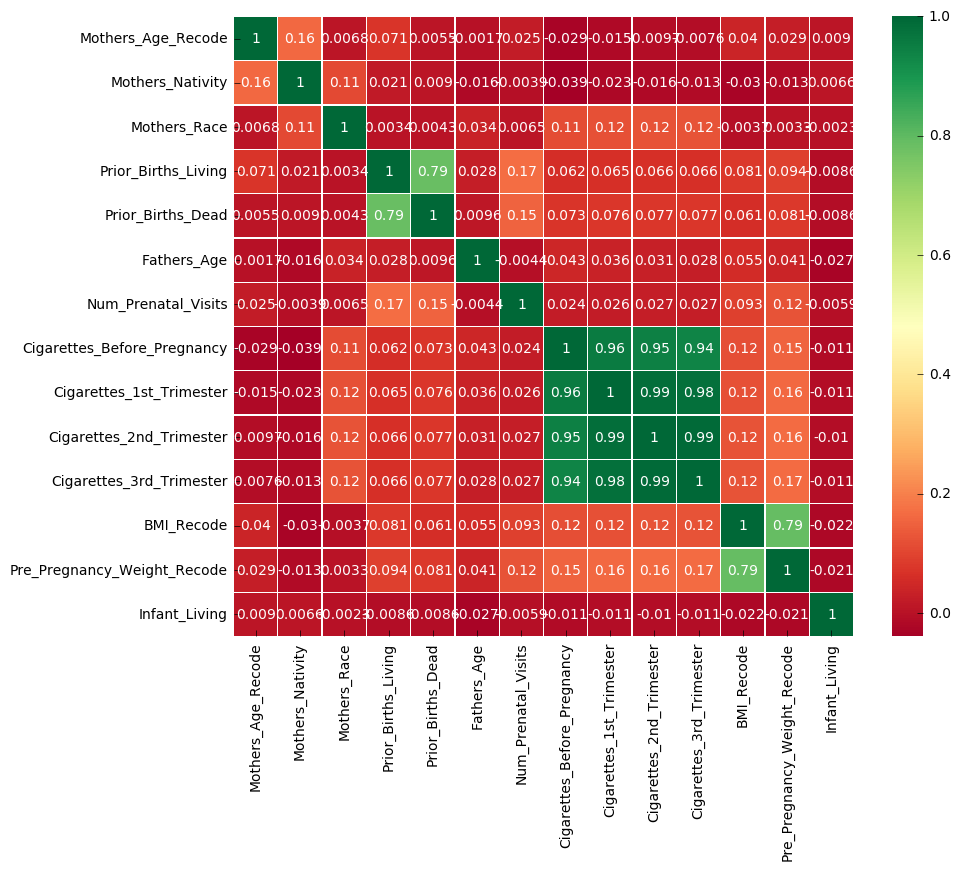

In [23]:

pndf_corr = pndf[['Mothers_Age_Recode','Mothers_Nativity','Mothers_Race','Prior_Births_Living',\
                  'Prior_Births_Dead','Fathers_Age','Num_Prenatal_Visits','Cigarettes_Before_Pregnancy',\
                  'Cigarettes_1st_Trimester','Cigarettes_2nd_Trimester','Cigarettes_3rd_Trimester','BMI_Recode',\
                  'Pre_Pregnancy_Weight_Recode','Infant_Living']]
"""
pndf_corr = pndf[['Mothers_Age_Recode','Mothers_Nativity','Mothers_Race','Prior_Births_Living',\
                  'Infant_Living']]
"""
# calculate the correlation matrix

#sns.heatmap(pndf_numeric.corr())
sns.heatmap(pndf_corr.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()
fig.savefig('Correlation.png') 

In [25]:
grpicds = icds.size()
#grpicds.dr
grpicds.head()

ICD10
A021    2
A022    2
A047    2
A049    1
A080    1
dtype: int64

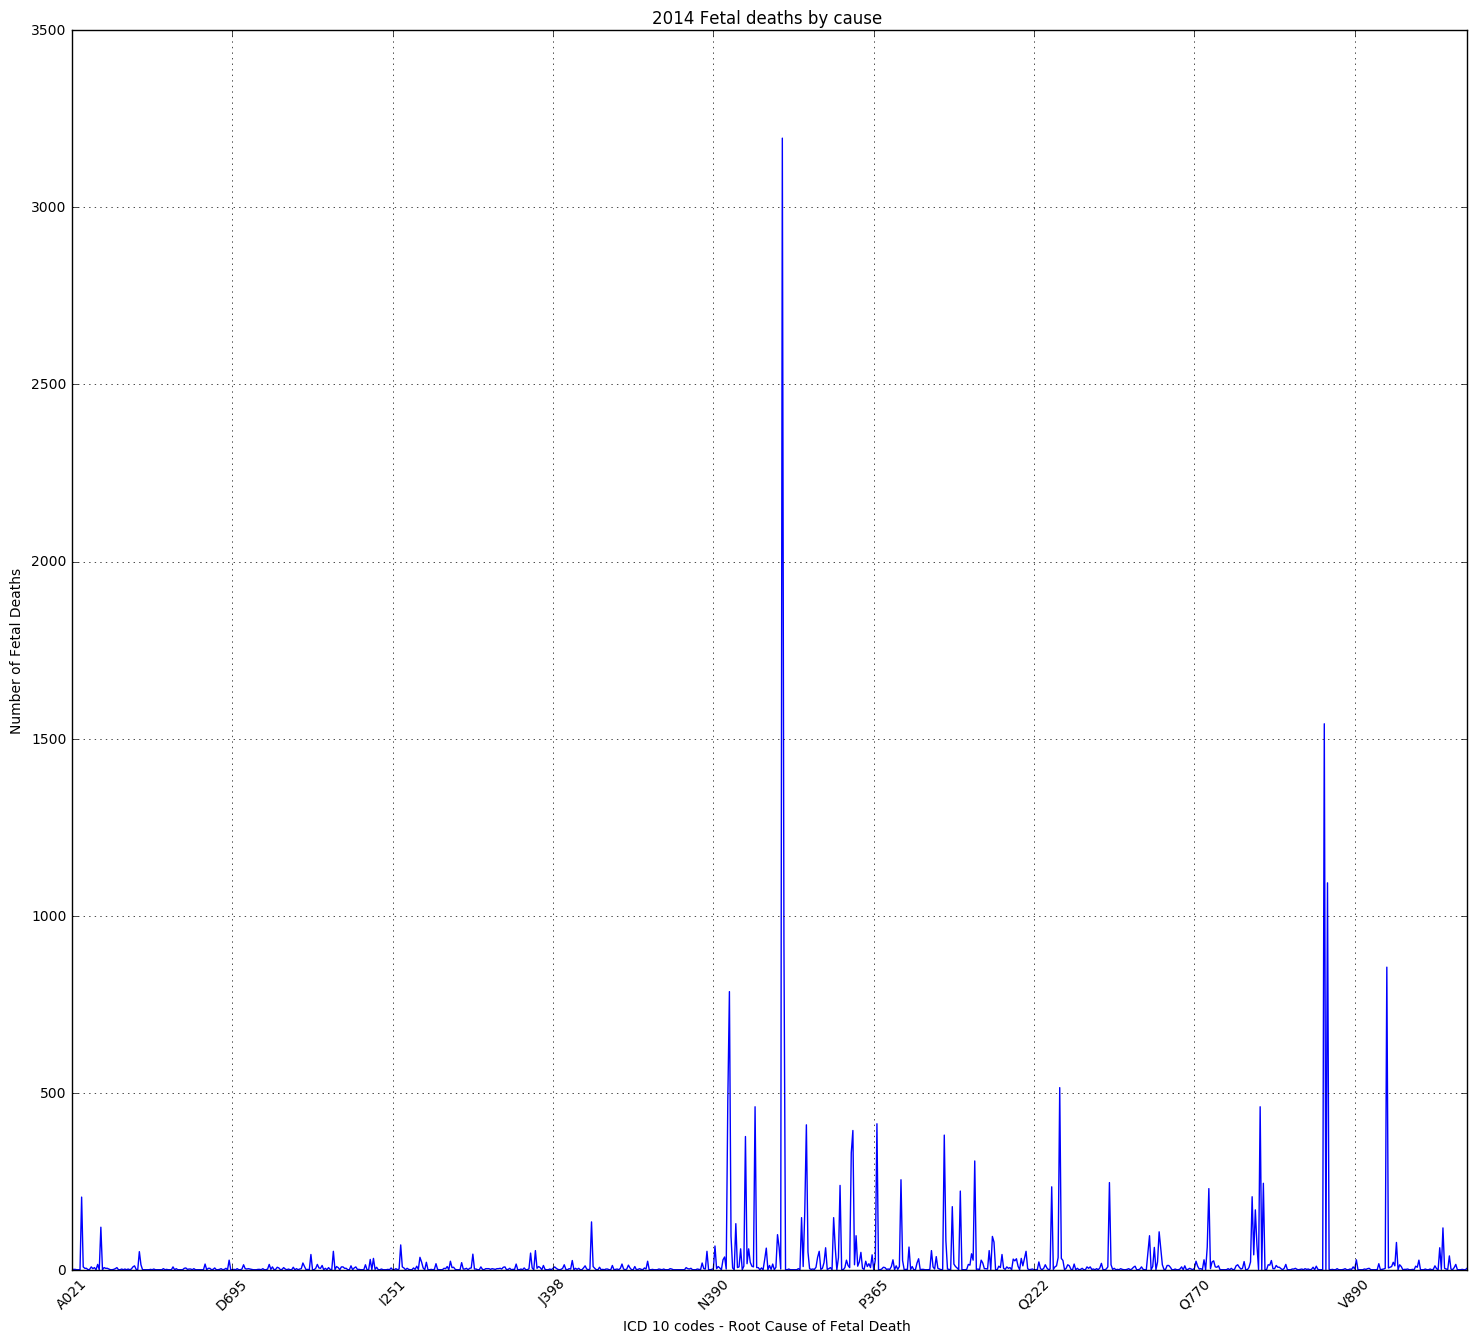

In [26]:
#plot of all root cause of fetal death(x-axis) and #deaths (y-axis)
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(18, 16), dpi= 180, facecolor='w', edgecolor='k')

plt.title("2014 Fetal deaths by cause ")
subplt = fig.add_subplot(1,1,1)
grpicds.plot(rot=45,grid=True ) #ax=subplt, logy=True

subplt.set_ylabel("Number of Fetal Deaths")
subplt.set_xlabel("ICD 10 codes - Root Cause of Fetal Death ")

plt.show()
fig.savefig('LeadingFetalCOD2014.png') 